In [4]:
!python -m pip install torch
!python -m pip install matplotlib
!python -m pip install numpy
!python -m pip install pandas


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 7.8/7.8 MB 23.8 MB/s eta 0:00:00
     ------------------------------------- 219.8/219.8 kB 13.1 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 23.5 MB/s eta 0:00:00
     ---------------------------------------- 56.0/56.0 kB ? eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 23.5 MB/s eta 0:00:00
     -------------------------------------- 106.9/106.9 kB 6.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
import torch
import torch.nn as nn


class SparseNeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, h, connections = None):
        super(SparseNeuralNetwork, self).__init__()
        h = [1] + h
        self.univariate_nn = nn.Sequential()
        layers = []
        self.masks = []
        for layer in range(1,len(h)):
            layers.append(nn.Linear(h[layer -1] * in_dim, h[layer] * in_dim))
            layers.append(nn.ReLU())
            self.masks.append(self.hidden_sparistiy_masks(h[layer] * in_dim, h[layer -1] * in_dim, h[layer - 1],h[layer]))
        self.univariate_nn = nn.Sequential(*layers)
        print(self.univariate_nn)
        self.multiply_weight_masks()
        self.fc2 = nn.Linear(out_dim, h[-1] * in_dim)
        if connections is not None:
            self.connection_mask = self.get_connection_mask(h[-1], in_dim, out_dim, connections)

    def multiply_connection_weight_masks(self):
        with torch.no_grad():
            for i in range(0,len(self.univariate_nn),2):
                self.fc2.weight.mul_(self.connection_mask)

    def multiply_grad_weight_masks(self):
        with torch.no_grad():
            for i in range(0,len(self.univariate_nn),2):
                self.fc2.weight.grad.mul_(self.connection_mask)

    def get_connection_mask(self, h, in_dim, out_dim, connections):
        mask = torch.zeros(out_dim, h * in_dim)
        for i in range(in_dim):
            for j in range(out_dim):
                if j in connections[i]:
                    print(mask[j,i * h:(i+1) * h])
                    mask[j,i * h:(i+1)* h] = 1
                else:
                    print(j, connections[i])
        print(mask)
        return mask

    def multiply_weight_masks(self):
        with torch.no_grad():
            for i in range(0,len(self.univariate_nn),2):
                self.univariate_nn[i].weight.mul_(self.masks[i // 2])

    def multiply_grad_masks(self):
        with torch.no_grad():
            for i in range(0,len(self.univariate_nn),2):
                self.univariate_nn[i].weight.grad.mul_(self.masks[i // 2])

    def hidden_sparistiy_masks(self, out_dim, in_dim, input_neurons, output_neurons):
        mask = torch.zeros(out_dim, in_dim)
        for i in range(0,in_dim):
            mask[i*output_neurons:output_neurons*(i + 1) , i*input_neurons:(i + 1)*input_neurons] = 1
        return mask

    def forward(self, x):
        hidden = self.univariate_nn(x)
        output = self.fc2(hidden)
        return output
h = 3 
in_dim = 5  
out_dim = 1  
#model = SparseNeuralNetwork(in_dim, out_dim, [4,8,4])
model = SparseNeuralNetwork(4, 4, [4,8,4], connections = [[1,3],[0,2],[1,3],[0,2]])
#input_data = torch.ones(1, in_dim)
#output = model(input_data)
#print(output)


Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
)
0 [1, 3]
tensor([0., 0., 0., 0.])
2 [1, 3]
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
1 [0, 2]
tensor([0., 0., 0., 0.])
3 [0, 2]
0 [1, 3]
tensor([0., 0., 0., 0.])
2 [1, 3]
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
1 [0, 2]
tensor([0., 0., 0., 0.])
3 [0, 2]
tensor([[0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.]])


In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt

class Neural_Kan(nn.Module):
    def __init__(self, shape, h):
        super(Neural_Kan, self).__init__()
        self.layers = nn.Sequential()
        for i in range(len(shape) - 1):
            print(shape[i], shape[i + 1])
            self.layers.append(SparseNeuralNetwork(in_dim = shape[i], out_dim = shape[i + 1], h = h))
    
    def forward(self,x):
        return self.layers(x)
    
    def train_loss(self,dataloader):
        criterion = nn.MSELoss()
        with torch.no_grad():
            for inputs, targets in dataloader:
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item()
        return total_loss

    def fit(self,dataloader, dataloader_test = '', epochs=100, lr=0.001):
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        self.train()
        loss_list = []
        for epoch in range(epochs):
            total_loss = 0.0
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                loss.backward()
                for models in self.layers:
                    models.multiply_grad_masks()
                optimizer.step()
            #test_loss = self.train_loss(dataloader_test)
            loss_list.append(total_loss)
            avg_loss = total_loss / len(dataloader)
            #avg_testloss = test_loss / len(dataloader_test)
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.7f})#, Test_loss: {avg_testloss:.7f} ")
            plt.plot(loss_list)

    def get_dataloader(self,f,num_samples=1000, in_dim=2, out_dim=1, batch_size = 32):
        X = torch.rand(num_samples, in_dim) 
        train_dataset = torch.utils.data.TensorDataset(X, f(X))
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
        return train_dataloader

model = Neural_Kan(shape = [2,1,1], h = [32])
def f(X):
    return torch.sin(torch.sum(X, dim=1, keepdim=True))
dataloader = model.get_dataloader(f)
print(dataloader)
model.fit(dataloader = dataloader, epochs=100, lr=0.001)
        

            


2 1
Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
)
1 1
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x64 and 1x64)

In [64]:
class Nomograph(nn.Module):
    def __init__(self,in_dim, out_dim = 1 ,h = 32):
        super(Nomograph, self).__init__()
        self.inner = SparseNeuralNetwork(in_dim, out_dim, h)
        self.outer_hidden = nn.Linear(out_dim,h)
        self.outer = nn.Linear(h,out_dim)
    def forward(self, x):
        #print(self.inner.fc1.weight.shape)
        #return self.inner(x)
        inner = F.relu(self.inner(x))
        outer_hidden = F.relu(self.outer_hidden(inner))
        return self.outer(outer_hidden)
        

2 2
Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=16, bias=True)
  (5): ReLU()
)
2 1
Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=16, bias=True)
  (5): ReLU()
)
Epoch [1/10], Loss: 0.5242
Epoch [2/10], Loss: 0.5056
Epoch [3/10], Loss: 0.4403
Epoch [4/10], Loss: 0.2088
Epoch [5/10], Loss: 0.1064
Epoch [6/10], Loss: 0.0808
Epoch [7/10], Loss: 0.0630
Epoch [8/10], Loss: 0.0463
Epoch [9/10], Loss: 0.0339
Epoch [10/10], Loss: 0.0240
Parameter containing:
tensor([[-0.0579,  0.0000],
        [-0.4264,  0.0000],
        [ 0.3061, -0.0000],
        [-0.5274, -0.0000],
        [ 0.8299, -0.0000],
        [-0.8010, -0.0000],
        [-0.4479,  0.0000],
        [ 0.3067, -0.0000],
        [-0.0000,

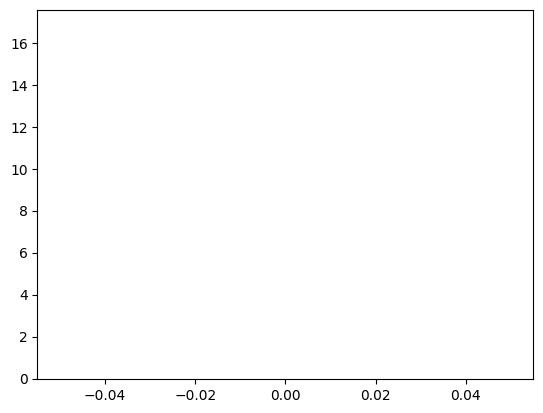

In [265]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, dataloader, num_epochs=100, lr=0.001):
    # Optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            loss.backward()
            for models in model.layers:
                models.multiply_grad_masks()
            optimizer.step()
        loss_list.append(total_loss)
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
        plt.plot(total_loss)


def generate_synthetic_data(num_samples=1000, in_dim=10, out_dim=1):
    # For simplicity, we'll generate some random data and create a linear relationship
    X = torch.randn(num_samples, in_dim)  # Random input data
    y = torch.sin(torch.sum(X, dim=1, keepdim=True))  # Simple sum across the input as a target

    # Let's assume our function is mapping input to some output (nomographic style)
    return X, y

in_dim = 2  
out_dim = 1
h = [8,32,8]
num_epochs = 10 
batch_size = 32
lr = 0.001  
X_train, y_train = generate_synthetic_data(num_samples=1000, in_dim=in_dim, out_dim=out_dim)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = Neural_Kan(shape = [2,2,1], h = h)
train(model, train_dataloader, num_epochs=num_epochs, lr=lr)
with torch.no_grad():
    for models in model.layers:
        for module in models.univariate_nn:
            if isinstance(module, nn.Linear):
                print(module.weight)

In [65]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        # GRU layer
        self.gru = nn.GRU(input_size, self.hidden_size, num_layers = 1)
        
        # Fully connected layer to map the hidden state to output
        self.fc = nn.Linear(self.hidden_size, input_size)
        
    def forward(self, x):
        batch_size = x.size(1)
        x.size(2)
        hidden_state = torch.ones(1,batch_size, self.hidden_size)#num_layer, batch_size, hidden_dim
        iters = 10
        print(x.shape)
        out,h = self.gru(x, hidden_state)
        print(out.shape)
        print(self.fc(out[:, -1, :]).shape)
        for t in range(iters):
            out, hidden_state = self.gru(x, hidden_state)
            x = self.fc(out[:, -1, :])
            x = x.reshape(-1,1,input_size) 
        return x

# Example usage
input_size = 5  # Input dimension
hidden_size = 10  # GRU hidden size

# Create the model
model = GRU(input_size, input_size*hidden_size)

# Example input (batch_size=10, seq_length=1, input_size=5)
x = torch.randn(10,1,input_size)

# Forward pass
output = model(x)
print(output.shape)  # Expected output shape: (batch_size, seq_length, output_size)


torch.Size([10, 1, 5])
torch.Size([10, 1, 50])
torch.Size([10, 5])
torch.Size([10, 1, 5])


In [70]:
for weight in model.gru.all_weights[0]:
    print(weight.shape)

def hidden_sparistiy_masks(out_dim=50, in_dim=5, input_neurons=1, output_neurons=10):
    mask = torch.zeros(out_dim, in_dim)
    for i in range(0,in_dim):
        mask[i*output_neurons:output_neurons*(i + 1) , i*input_neurons:(i + 1)*input_neurons] = 1
    mask = torch.vstack([mask for i in range(3)])
    return mask
print(hidden_sparistiy_masks().shape)

torch.Size([150, 5])
torch.Size([150, 50])
torch.Size([150])
torch.Size([150])
torch.Size([150, 5])


In [26]:
import torch
from torch import nn
rnn = nn.GRU(10, 20, 1)
for param in rnn.all_weights[0]:
    print(param.shape)
x = torch.randn(1,1,10)
h0 = torch.randn(1,1, 20)
output, hn = rnn(x, h0)
print(output)

torch.Size([60, 10])
torch.Size([60, 20])
torch.Size([60])
torch.Size([60])
tensor([[[-1.1765, -0.6020,  0.2905, -0.8836, -0.5612,  0.3081,  0.4284,
          -0.0191,  0.0199, -0.6109, -0.1067,  0.4155,  0.3936, -0.9498,
           1.8194,  0.5143,  1.2690, -1.0503,  0.2242,  0.1080]]],
       grad_fn=<StackBackward0>)
